# ISYE 6740 - Implementing EM and Optimization
## Homework 4 
## Zi Liu

### Section 1.Implementing EM for MNIST dataset

Implement the EM algorithm for fitting a Gaussian mixture model for the MNIST dataset. We reduce the dataset to be only two cases, of digits “2” and “6” only. Thus, you will fit GMM with C = 2. Use the data file data.mat or data.dat. True label of the data are also provided in label.mat and label.dat

The matrix images is of size 784-by-1990, i.e., there are totally 1990 images, and each column of the matrix corresponds to one image of size 28-by-28 pixels (the image is vectorized; the original image can be recovered by map the vector into a matrix.)

First use PCA to reduce the dimensionality of the data before applying to EM. We will put all "6" and "2" digits together, to project the original data into 5-dimensional vectors.

#### (a) Select one image of "2" and one image of "6", and visualize the two images.

In [2]:
#Import all packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
plt.style.use('seaborn-white')

In [3]:
images = np.loadtxt("data/data.dat", dtype='f')
labels = np.loadtxt("data/label.dat", dtype='f')

In [4]:
images = images.T

In [5]:
pd.DataFrame(images)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1988,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
pd.DataFrame(labels)

,0
0,2.0
1,2.0
2,2.0
3,2.0
4,2.0
...,...
1985,6.0
1986,6.0
1987,6.0
1988,6.0


By printing the labels array, I can tell index 0 and index 1989 are image 2 and 6, respectively

Text(0.5, 1.0, 'Raw Image of 6')

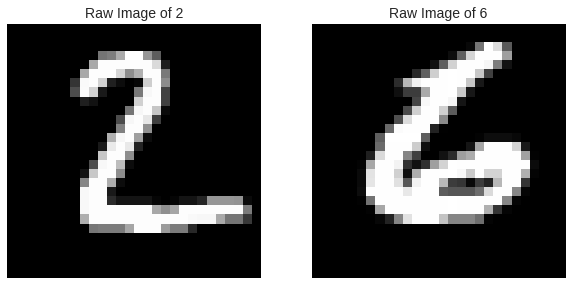

In [7]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].axis("off")
axes[0].imshow(images[0].reshape((28,28)).T, cmap='gray')
axes[0].set_title("Raw Image of 2", fontsize=14)
axes[1].axis("off")
axes[1].imshow(images[1989].reshape((28,28)).T, cmap='gray')
axes[1].set_title("Raw Image of 6", fontsize=14)

#### (b) Write down detailed expression of the E-step and M-step in the EM algorithm

<font size="3">

<ins>**Problem Definition: Obtain parameters that maximizes the log−likelihood function**</ins>

$l(\theta ; D) = log\Pi_{i=1}^m(\sum\limits_{z^i=1}^k p(x^i, z^i \vert \theta))$ 


1)<ins> Expectation step (E-step):</ins> take expectation over posterior distribution conditioning on data: it can be shown this forms a lower bound (in the t-th iteration)
    
    
$l(\theta ; D) \geq f(\theta) = E_{q(z^1, z^2, ..., z^m \vert \theta^t)}[log\Pi_{i=1}^m(\sum\limits_{z^i=1}^k p(x^i, z^i \vert \theta))]$ 


$q(z^1, z^2, ..., z^m)$: posterior distribution of the latent variables in t-th iteration 

$q(z^1, z^2, ..., z^m) = \Pi_{i=1}^m p(z^i \vert x^i, \theta^t)$

For each data point $x^i$, compute $\tau$, $p(z^i = k \vert x^i)$ for each k, which is the probability of data point x come from Gaussian k 

$\tau_{k}^i = p(z^i = k \vert x^i, \theta^t)$ 
  
$ = \frac{p(x^i \vert z^i = k)p(z^i = k)}{\Sigma_{k'=1,..,K}p(z^i=k', x^i)}$
    
$ = \frac{\pi_{k}N(x^i \vert \mu_{k}, \Sigma_{k})}{\Sigma_{k'=1,..,K}\pi_{k'} N(x^i \vert \mu_{k'}, \Sigma_{k'})}$  

Since the Gaussian density function is given by:
    
$N(x^i \vert \mu_{k}, \Sigma_{k}) = \frac{1}{\sqrt{(2\pi)^n \vert\Sigma\vert}}\exp^{-\frac{1}{2}(x^i-\mu)^{\intercal}\Sigma^{-1}  (x^i-\mu)}$

Therefore:

$\tau_{k}^i = \frac{\pi_{k}\frac{1}{\sqrt{(2\pi)^n \vert\Sigma_{k}\vert}}\exp^{-\frac{1}{2}(x^i-\mu_{k})^{\intercal}\Sigma_{k}^{-1}  (x^i-\mu_{k})}}{\Sigma_{k'=1...K}\pi_{k'}\frac{1}{\sqrt{(2\pi)^n \vert\Sigma_{k'}\vert}}\exp^{-\frac{1}{2}(x^i-\mu_{k'})^{\intercal}\Sigma^{-1}  (x^i-\mu_{k'})}}$ 
    
And we need to drop the ${\sqrt{(2\pi)}^n}$ factor from the numerator and denominator expression because it will be canceled out:

$\tau_{k}^i = \frac{\pi_{k}\frac{1}{\sqrt{\vert\Sigma_{k}\vert}}\exp^{-\frac{1}{2}(x^i-\mu_{k})^{\intercal}\Sigma_{k}^{-1}  (x^i-\mu_{k})}}{\Sigma_{k'=1...K}\pi_{k'}\frac{1}{\sqrt{\vert\Sigma_{k'}\vert}}\exp^{-\frac{1}{2}(x^i-\mu_{k'})^{\intercal}\Sigma^{-1}  (x^i-\mu_{k'})}}$ 
</font>
  
  
$\tau_{k}^i$ is updated based on the given current $(\pi_k, \mu_k, \Sigma_k)$


<font size="4">
    
Compute the expectation for $ f(\theta)$:

$f(\theta) := E_{q(z^1, z^2, ..., z^m \vert \theta^t)}[log\Pi_{i=1}^m(\sum\limits_{z^i=1}^k p(x^i, z^i \vert \theta))]$  

    
$ = \Sigma_{i=1}^m E_{p(z^i \vert x^i, \theta^t)}[logp(x^i, z^i \vert \theta)] $  
    
$ = \Sigma_{i=1}^m E_{p(z^i \vert x^i, \theta^t)}[log\pi_{z^i}N(x^i \vert \mu_{z^i}, \Sigma_{x^i})] $

  
Expand log of Gaussian density $logN(x^i \vert \mu_{z^i}, \Sigma_{z^i})$


$ f(\theta) = \Sigma_{i=1}^m E_{p(z^i \vert x^i, \theta^t)}[log{\pi_{z^i}} - \frac{1}{2}(x^i - \mu_{z^i})^\intercal \Sigma_{z^i}^{-1}(x^i - \mu_{z^i}) -  \frac{1}{2}log\vert\Sigma_{z^i}\vert - \frac{n}{2}log(2\pi)] $  
    
$ = \Sigma_{i=1}^m\Sigma_{k=1}^K\tau_{k}^i[log{\pi_{z^i}} - \frac{1}{2}(x^i - \mu_{z^i})^\intercal \Sigma_{z^i}^{-1}(x^i - \mu_{z^i}) -  \frac{1}{2}log\vert\Sigma_{z^i}\vert - \frac{n}{2}log(2\pi)]$
</font>


2)<ins> Maximize step (M-step):</ins> take expectation over $ f(\theta)$, maximize the parameter. To do so we take the partial derivative of the funcation and set to 0

$ f(\theta) = \Sigma_{i=1}^m\Sigma_{k=1}^K\tau_{k}^i[log{\pi_{z^i}} - \frac{1}{2}(x^i - \mu_{z^i})^\intercal \Sigma_{z^i}^{-1}(x^i - \mu_{z^i}) -  \frac{1}{2}log\vert\Sigma_{z^i}\vert - \frac{n}{2}log(2\pi)] $

Need to find $\pi_{k}$ and we know $\Sigma_{k=1}^K\pi_{k} = 1$

Form the Lagrangian:

$L = \Sigma_{i=1}^m\tau_{k}^i[log\pi_{k} + other terms] + \lambda(1-\Sigma_{i=1}^K\pi_{k}) $


Take the partial derivative and set it to zero:

<font size= "4">
$\frac{\partial L}{\partial \pi_{k}} = \Sigma_{i=1}^m\frac{\tau_{k}^i}{\pi_{k}} - \lambda = 0$


Note we know that the summation of all mixing coefficients $\pi$ equals one. In addition, we know that summing up the probabilities $\tau$ over k will also give us 1. Thus we get $\lambda$  = m

$ \Rightarrow \pi_{k} = \frac{1}{m}\Sigma_{i=1}^m\tau_{k}^i$
  

$ = \frac{1}{m}\Sigma_{i=1}^m\frac{\pi_{k}\frac{1}{\sqrt{\vert\Sigma_{k}\vert}}\exp^{-\frac{1}{2}(x^i-\mu_{k})^{\intercal}\Sigma_{k}^{-1}  (x^i-\mu_{k})}}{\Sigma_{k'=1...K}\pi_{k'}\frac{1}{\sqrt{\vert\Sigma_{k'}\vert}}\exp^{-\frac{1}{2}(x^i-\mu_{k'})^{\intercal}\Sigma^{-1}  (x^i-\mu_{k'})}}$


we differentiate Q with respect to µ and $\Sigma $, equate the derivative to zero and then solve for the parameters by making use of the log-likelihood equation. The results are shown as following:

$\mu_{k} = \frac{\Sigma_{i=1}^m\tau_{k}^i X_m}{\Sigma_{i=1}^m\tau_{k}^i}$

    
$\Sigma_{k} = \frac{\Sigma_{i=1}^m\tau_{k}^i (X_m - \mu_{k})(X_m - \mu_{k})^T}{\Sigma_{i=1}^m\tau_{k}^i}$    
    
</font>

#### (c) Implement EM algorithm yourself. 
Use the following initialization: 

• initialization for mean: random Gaussian vector with zero mean

• initialization for covariance: generate two Gaussian random matrix of size n-by-n: S1 and S2, and initialize the covariance matrix for the two components

Plot the log-likelihood function versus the number of iterations to show your algorithm
is converging.

##### Step 1: Perform PCA to reduce the images to 5 dimensions

In [8]:
def PCA_algo(data):
    assert type(data) is np.ndarray
    assert len(data.shape) == 2
    
    # step 1. Subtract the mean of each variable
    data_meaned = data -np.mean(data,axis = 0)
    
    # step 2. Calculate the Covariance Matrix
    cov_matrix = np.cov(data_meaned, rowvar = False)
    
    #step 3. Calculating Eigenvalues and Eigenvectors of the covariance matrix
    eigen_values , eigen_vectors = np.linalg.eigh(cov_matrix)

    #step 4. sort the eigenvalues in descending order
    sort_idx = np.argsort(eigen_values)[::-1]

    eigen_values_s = eigen_values[sort_idx]
    eigen_vectors_s = eigen_vectors[:,sort_idx]
    
    return eigen_values_s,eigen_vectors_s

In [9]:
eigen_values_1, eigen_vectors_1 = PCA_algo(images)

In [10]:
# project the original data into 5-dimensional vectors
project = images @ eigen_vectors_1[:,:5]

In [11]:
pd.DataFrame(project)

,0,1,2,3,4
0,-1.208191,-0.174419,0.166703,6.446482,-1.337619
1,-1.435266,-5.271455,0.285528,2.820486,1.591432
2,-0.695379,-1.107195,-0.616334,4.855767,0.166167
3,-0.573259,-2.084398,1.320592,2.676489,-1.305482
4,-0.493528,-2.902178,0.368928,2.530739,0.457135
...,...,...,...,...,...
1985,4.081742,-4.527777,0.427191,3.466353,0.825053
1986,1.773561,-1.900981,2.291727,2.881905,0.634671
1987,0.699659,-2.626749,3.265817,2.769479,-0.754880
1988,3.333729,-3.802714,4.000521,7.396613,-0.141478


##### Initialization

In [12]:
def initiate_components(x, k=2):
        
        '''
        Input:
        
        x (m,n) : Array of shape (m,n) with m datapoints and n features
        k : int, the number of components
        
        Output:
        
        theta:[],list of nested lists each corresponding to each cluster. 
        Each nested list contains the following items: [mu, cov, pi,tau,total]
            1.A mean µ that defines its centre.
            2.covariance ∑ that defines its width
            3.A mixing probability 𝜋 that defines how big or small the Gaussian function will be.
            4.Tau - Set as None for future use purpose
            5.Total - Set as None for future use purpose

        '''
        np.random.seed(123)
        
        theta = []
        
        for i in range(k):
            mu = np.random.normal(0,0.1,x.shape[1])
            cov = np.identity(x.shape[1], dtype=np.float64)
            pi = 1/k
            tau = None
            total = None
            theta.append([mu,cov,pi,tau,total])

        return theta


##### create a function to calculate gaussian density:

In [13]:
def gaussian3(X, mu, cov):
            
    '''
    Input:

    X (m,n) : Array of shape (m,n) with m datapoints and n features
    mu : Array of shape (n,1) with the mean for the component
    cov : Array of shape (n,n) representing the covariance matrix

    Output:
    prob: Array of shape (m,1) with the probabilities that the datapoints are coming from the normal distribution with mean mu and covariance matrix cov
    '''
    prob = []
    y1 = multivariate_normal.pdf(X,mu,cov)
    
    for i in y1:
        prob.append([i])
            
    return np.array(prob)
    

##### Expectation step: calcualte tau

In [14]:
def expectation_step(X, theta):
    '''
    Input:
        X (m,n) : Array of shape (m,n) with m datapoints and n features    
        theta: list of nested lists each corresponding to each k. Each nested list contains the following items:
        [mu,cov,pi,tau,total]
        
    Output:
        theta: list of nested lists each corresponding to each k. Each nested list contains the following items:
        [mu,cov,pi,tau,total]
    '''
    m,n = X.shape
    totals = np.zeros((m, 1), dtype=np.float64)
    
    for t in theta:
        mu_k = t[0]
        cov_k = t[1]
        pi_k = t[2]
        
        gamma = (pi_k * gaussian3(X, mu_k, cov_k)).astype(np.float64)
        
        #calculate the sum of tau
        for i in range(m):
            totals[i] += gamma[i]
        
        t[3] = gamma
        t[4] = totals
        
    #calculate the tau for each datapoint m, and update it into the theta array   
    for t in theta:
        t[3] /= t[4]
        
    return theta

##### Maximization step: update mu,cov,pi

In [15]:
def maximization_step(X, theta):
    '''
    Input:
        X (m,n) : Array of shape (m,n) with m datapoints and n features    
        theta: list of nested lists each corresponding to each k. Each nested list contains the following items:
        [mu,cov,pi,tau,total]
        
    Output:

        theta: list of nested lists each corresponding to each k. Each nested list contains the following items:
        [mu,cov,pi,tau,total]
    '''
    m,n = X.shape 
    
    for t in theta:
        tau = t[3]
        N_k = np.sum(tau)
        
        #compute the new pi
        pi_k = N_k / m
        t[2] = pi_k
        
        #compute the new mu
        mu_k = np.sum(tau.reshape(-1,1)*X,axis = 0) / N_k
        t[0] = mu_k
        
        #compute the new cov
        cov_k = np.zeros((n,n))
        
        for j in range(m):
            diff = (X[j]- mu_k).reshape(-1,1)
            cov_k += tau[j] *np.dot(diff,diff.T)
        
        cov_k /= N_k
        t[1] = cov_k
        
    return theta

##### Define a functiont to compute the log-likelihood

In [16]:
def likehood(theta):
    '''
    Input:
        
    theta: list of nested lists each corresponding to each k. Each nested list contains the following items:
    [mu,cov,pi,tau]
        
    Output:
        
    l : Computed log-likelihood value
    '''
    tau = np.array([t[3] for t in theta]).T
    pi = np.array([t[2] for t in theta])
    
    l = np.sum(np.log(np.sum(pi*tau,axis = 1)))
    
    return l

##### Combine all components together: EM algorithm

In [17]:
# EM ALGORITHM
def train_EM(X,num_cluster=2,iterations=5):
    '''
     Input:
        x (m,n) : Array of shape (m,n) with m datapoints and n features
        num_cluster: int, decide the number of clusters
        iternations: int, the number of iterations
 
    Output:
        clusters: Each nested list contains the following items: [mu,cov, pi, tau, total]
        likelihoods: list, the likeihood score 
    '''
    clusters = initiate_components(X,k = num_cluster)
    likelihoods = []
    
    for i in range(iterations):
        expectation_step(project,clusters) 
        maximization_step(project,clusters)
        likelihoods.append(likehood(clusters))
    
    return clusters, likelihoods

In [18]:
clusters, likelihoods = train_EM(project,num_cluster=2,iterations=20)

##### Plot the log-likelihood values by iteration
Note the algorithm reached to converge at around 10th iteration

(1.0, 20.0)

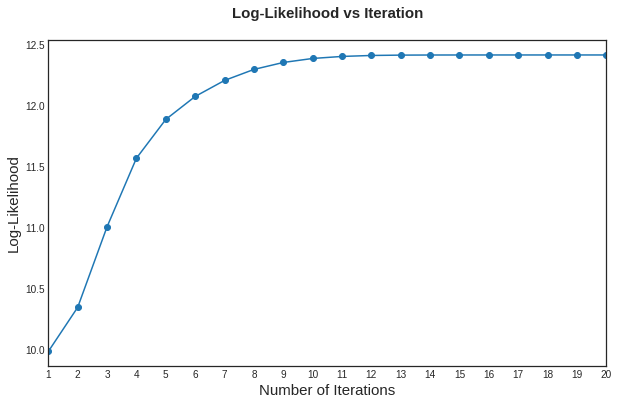

In [19]:
plt.figure(figsize=(10,6))
plt.title("Log-Likelihood vs Iteration\n", fontsize=15, weight='bold')
plt.plot(np.arange(1,21),likelihoods)
plt.scatter(np.arange(1,21),likelihoods)
plt.xlabel('Number of Iterations',fontsize=15)
plt.ylabel("Log-Likelihood",fontsize=15)
plt.xticks(np.arange(1,21))
plt.xlim(1,20)

#### (c) Report, the fitting GMM model when EM has terminated in your algorithms, including the weights for each component and the mean vectors (please reformat the vectors into 28-by-28 images and show these images in your submission). Ideally, you should be able to see these means corresponds to “average” images.

In [20]:
mu_0 = clusters[0][0]
mean_reconst_0 = mu_0 @ eigen_vectors_1[:,:5].T

mu_1 = clusters[1][0]
mean_reconst_1 = mu_1 @ eigen_vectors_1[:,:5].T

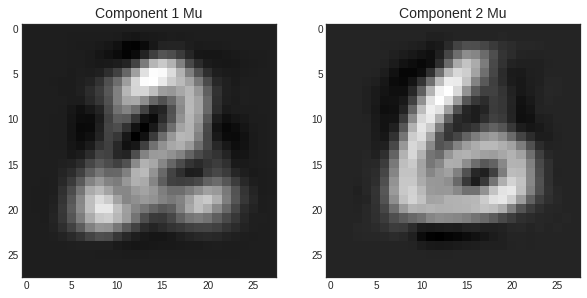

In [21]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(mean_reconst_0.reshape(28,28).T,cmap='gray')
axes[0].set_title("Component 1 Mu", fontsize=14)
axes[1].imshow(mean_reconst_1.reshape(28,28).T,cmap='gray')
axes[1].set_title("Component 2 Mu", fontsize=14);

##### report the two 784-by-784 covariance matrices by visualizing their intensities (e.g., using a gray scaled image)

In [22]:
sigma_0 = clusters[0][1]
sigma_1 = clusters[1][1]

# Reconstruct weights back into our original vector space:
reconst_0 = eigen_vectors_1[:,:5] @ sigma_0 @ eigen_vectors_1[:,:5].T
reconst_1 = eigen_vectors_1[:,:5] @ sigma_1 @ eigen_vectors_1[:,:5].T

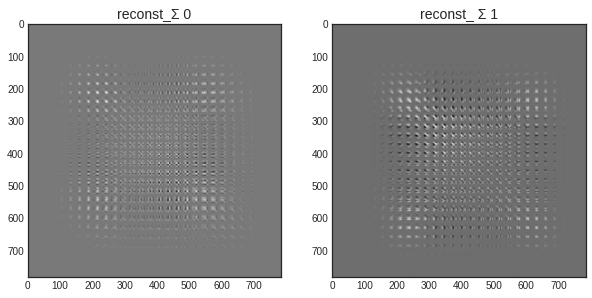

In [23]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(reconst_0.reshape(784,784),cmap='gray')
axes[0].set_title("reconst_\u03A3 0", fontsize=14)
axes[1].imshow(reconst_1.reshape(784,784),cmap='gray')
axes[1].set_title("reconst_ \u03A3 1", fontsize=14);

#### (e) Use the tau to infer the labels of the images, and compare with the true labels.
Report the mis-classification rate for digits \2" and \6" respectively. Perform K-means
clustering with K = 2 (you may call a package or use the code from your previous
homework). Find out the mis-classification rate for digits \2" and \6" respectively,
and compare with GMM. Which one achieves the better performance?

##### Note: From the observation in question 3 above, k = 1 represents the label = 2 and k = 2 represents label = 6.  The accuracy rate for the classification is based on a probability greater than 0.5.

In [24]:
tau_2 = clusters[0][3].reshape(-1,)
tau_6 = clusters[1][3].reshape(-1,)
print('The mis-classification rate for label 2 is:',np.round(100*((tau_2 > 0.5) != (labels==2)).mean(),2), '%')
print('The mis-classification rate for label 6 is:',np.round(100*((tau_6 > 0.5) != (labels==6)).mean(),2), '%')

The mis-classification rate for label 2 is: 3.37 %
The mis-classification rate for label 6 is: 3.37 %


##### Use k-means from sklearn package to train the model:

In [25]:
#Train and fit the kmeans model
kmeans = KMeans(n_clusters=2, random_state=0).fit(images)

In [26]:
#Rename the prediction result from 0 to 2, 1 to 6 respectively
predict_results = kmeans.labels_
predict_results[predict_results==0]=2
predict_results[predict_results==1]=6
predict_results

array([2, 2, 2, ..., 2, 6, 6], dtype=int32)

In [27]:
print('The mis-classification rate for k-means algo is:',np.round(100*(predict_results != labels).mean(),2), '%')

The mis-classification rate for k-means algo is: 6.23 %


##### The mis-classfication rate for k-means is 6.23%  and it is higher than the results from the GMM model. That means GMM has a better performance in terms of classification.

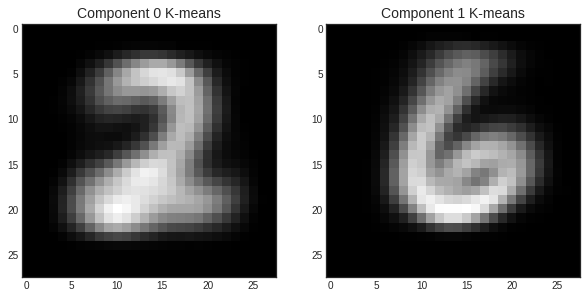

In [28]:
fig, axes = plt.subplots(1,2,figsize=(10,5))
axes[0].imshow(kmeans.cluster_centers_[0].reshape(28,28).T,cmap='gray')
axes[0].set_title("Component 0 K-means", fontsize=14)
axes[1].imshow(kmeans.cluster_centers_[1].reshape(28,28).T,cmap='gray')
axes[1].set_title("Component 1 K-means", fontsize=14);

### Section 2.Optimization

Consider a simplified logistic regression problem. Given m training samples (xi; yi), i = 1,... ,m. The data xi (note that we only have one feature for each sample), and yi= {0,1}. To fit a logistic regression model for classification, we solve the following optimization problem, where theta is a parameter we aim to find:

$$max_θl(θ)$$

where the log-likelihood function

$$l(θ) = \sum^m_{i=1} \{-log(1+exp\{-θx^i\}) + (y^i-1)θx^i\}$$

##### Q1a Show step-by-step mathematical derivation for the gradient of the cost function $l(\theta)$ in (1).

$$l(θ) = \sum^m_{i=1} \{-log(1+exp\{-θx^i\}) + (y^i-1)θx^i\}$$

$$\frac{\partial l(θ)}{\partial θ} = \frac{\partial}{\partial θ}\sum^m_{i=1} \{-log(1+exp\{-θx^i\}) + (y^i-1)θx^i\}  $$

$$ = \sum^m_{i=1} \frac{\partial}{\partial θ}-log(1+exp\{-θx^i\} + \sum^m_{i=1} \frac{\partial}{\partial θ}(y^i-1)θx^i $$

Because: $$ \frac{{\partial}{\log(f(x))}}{{\partial}{x}} = \frac{f'(x)}{f(x)}$$
 

Therefore $$= \sum^m_{i=1}-\frac{(1+exp\{-θx^i\})'}{1+exp\{-θx^i\}} + \sum^m_{i=1}(y^i-1)x^i $$

$$ = \sum^m_{i=1}\frac{x^iexp\{-θx^i\}}{1+exp\{-θx^i\}} + \sum^m_{i=1}(y^i-1)x^i$$

$$= \sum^m_{i=1}\frac{x^iexp\{-θx^i\}}{1+exp\{-θx^i\}} + (y^i-1)x^i $$

#### Q1b Write a pseudo-code for performing gradient descent to find the optimizer $θ^*$. 

1. Initialize $\theta $ and $\alpha$, where $\theta$ is any parameter on which the cost function depends on for the logistic regression and $\alpha$ is the learning rate.

2. Do: For each iteration:
            a. perform the following calculation given a number of iterations:
    
$$ Δ\theta = \alpha \sum^m_{i=1}\frac{x^iexp\{-θx^i\}}{1+exp\{-θx^i\}} + (y^i-1)x^i $$

            b. update:
   
$$\theta_(new)  = \theta_(old) +  Δ\theta$$ 
    
            till satisfied

#### Q1c Write the pseudo-code for performing the stochastic gradient descent algorithm to solve the training of logistic regression problem (1). Please explain the difference between gradient descent and stochastic gradient descent for training logistic regression.

1. Initialize $\theta $ and $\alpha$, where $\theta$ is any parameter on which the cost function depends on for the logistic regression and $\alpha$ is the learning rate.

2. Randomly shuffle the training dataset $S_t$

3. Do: For each iteration:
           For sample training dataset St:
                 perform the following calculation:
$$ \theta_(new)  = \theta_(old) + \alpha \sum_{{i}\in{S_{t}}} \frac{x^iexp\{-θx^i\}}{1+exp\{-θx^i\}} + (y^i-1)x^i, while Δ\theta > \epsilon $$
                 till satisfied

The difference between gradient descent and stochastic gradient descent is at the update step the gradient descent is computing the gradient using all the training data, whereas for stochastic gradient descent only selects a sample dataset for computing the gradient to update the theta.

#### Q1d Derive the Hessian matrix of $l(θ)$ and based on this, show the training problem (1) is concave (note that in this case, since we only have one feature, the Hessian matrix is just a scalar). Explain why the problem can be solved efficiently and gradient descent will achieve a unique global optimizer, as we discussed in class

Hessian matrix is defined as the second derivative of the likelihood function of $l(θ)$. It is equals to: $\frac{\partial^2 l(\theta)}{\partial \theta^2}$

$$\frac{\partial^2 l(θ)}{\partial θ^2} =   \frac{\partial}{\partial θ}\sum^m_{i=1}\frac{x^iexp\{-θx^i\}}{1+exp\{-θx^i\}} + (y^i-1)x^i$$

$$= \sum^m_{i=1} \frac{\partial}{\partial θ}\frac{x^i y^i exp\{-θx^i\} + x^i y^i-x^i}{1+exp\{-θx^i\}} $$

$$= \sum^m_{i=1} \frac{(-x_i^2 y^i exp\{-θx^i\})  (1+exp\{-θx^i\}) - (-x^i exp\{-θx^i\}) (x^i y^i exp\{-θx^i\} + x^i y^i-x^i)}{(1+exp\{-θx^i\})^2} = $$

$$ = -\sum^m_{i=1} \frac{x_i^2 exp\{-θx^i\}}{(1+exp\{-θx^i\})^2}$$ 

The term $-\sum^m_{i=1} \frac{x_i^2 exp\{-θx^i\}}{(1+exp\{-θx^i\})^2}$  is always negative with the quadratic fraction term being positive. Therefore the optimization of $l(θ)$ is a concave problem.

### Reference link:
https://towardsdatascience.com/gaussian-mixture-models-explained-6986aaf5a95
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html
https://towardsdatascience.com/mathematical-intuition-behind-gradient-descent-f1b959a59e6d
https://towardsdatascience.com/optimization-loss-function-under-the-hood-part-ii-d20a239cde11
https://www.quora.com/Whats-the-difference-between-gradient-descent-and-stochastic-gradient-descent